In [24]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

df_part1 = pd.read_csv("data/train1.csv", index_col="id")
df_part2 = pd.read_csv("data/train2.csv", index_col="id")

# Concatenate dataframes
df = pd.concat([df_part1, df_part2])

# Turn the date column into datetime64
df["date"] = pd.to_datetime(df["date"])

## Exploration


In [25]:
df.head()

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


In [26]:
df.dtypes

date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
dtype: object

In [27]:
# List all product families
df.family.unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [28]:
def group_dataframe(input_df: pd.DataFrame) -> pd.DataFrame:
    return (
        input_df.groupby(["date", "store_nbr", "family"])["sales"]
        .sum()
        .reset_index()
        .pivot(index="date", columns=["store_nbr", "family"])
    )

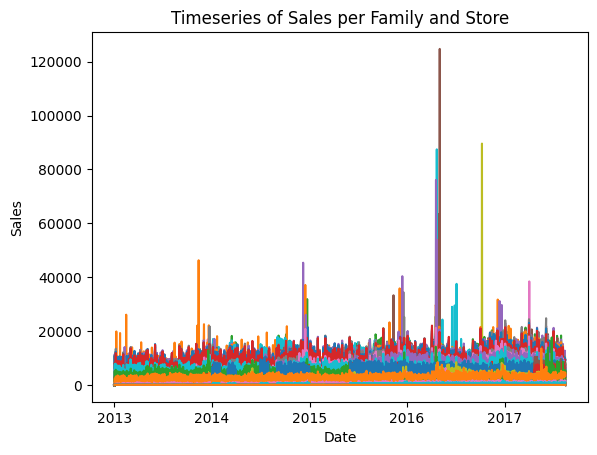

In [29]:
plt.plot(group_dataframe(df))
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Timeseries of Sales per Family and Store")
plt.show()

## Pre-processing


In [30]:
processed_df = df.copy()

# Turn the family column into numerical data
# processed_df = pd.get_dummies(processed_df, columns=["family"])

In [31]:
# Split to test and train sets
train = processed_df.query("date < '2017-08-01'")
test = processed_df.query("date >= '2017-08-01'")